In [1]:
##
## ResNet50 смотрим результативность (реализация взята с github keras/application):
##                  https://github.com/fchollet/keras/tree/master/keras/applications
##
## 2017-07-16
##
##  Смотрим результативность на наборах 224x244x3 JPG 
##
##
##
##

In [2]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import sklearn.metrics as skm

from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
sys.path.append('../Python')
from helper import paths_input, formImExt, formImHist
from estimate import confusion_matrix, getConfusion, getRocAUC, getProb01, getProbX01, getTh, estimateResult

In [6]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential,save_model,load_model, Model, Input
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Conv2D

from keras.applications.resnet50 import ResNet50, preprocess_input

from keras.layers.normalization import BatchNormalization
import keras.optimizers
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import keras.backend as K

Using TensorFlow backend.


In [7]:
keras.__version__

'2.0.4'

In [8]:
trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
trDirI = trDirTIF
teDirI = teDirTIF
trWork, teWork = '../Work/Train', '../Work/Test'
trDirI,teDirI, teDirJPG, trWork, teWork

('../Data/train-tif-v2',
 '../Data/test-tif-v2',
 '../Data/test-jpg-v2',
 '../Work/Train',
 '../Work/Test')

In [9]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [10]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [11]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    #labels_df[label].astype(np.int8)
# Display head
#labels_df.head()


In [12]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [13]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
labelList[:6,:]
#labels_df.head()

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [14]:
len(labels_df.tags.unique())

449

In [15]:
#!rm ../Temp/Batch/*.npy

In [16]:
# TODO: сделать все файлы одинаковыми, размера size. Касается последнего, связано с краевыми круговой эффектами выборки в конце.

def generate_batches ( names_tags_df, dirIn, output_shape, classes=17, ext='.jpg', size=5000) :
    xx = np.zeros((size,output_shape[0],output_shape[1],output_shape[2]),dtype=np.float32);
    yy = np.zeros((size,classes),dtype=np.uint8);
    
    iijj = 0;
    
    for ii in range(0,len(names_tags_df),size) :
        yy    = labels_df[ii:min(ii+size,len(names_tags_df))].values[:,2:].astype(np.uint8);
        files = labels_df[ii:min(ii+size,len(names_tags_df))].image_name.tolist()
        files = [x+ext for x in files]
        if len(files)<size :
            xx = np.zeros((len(files),output_shape[0],output_shape[1],output_shape[2]),dtype=np.float32);
        for i in range(len(files)) :
            nf    = os.path.join(dirIn,files[i])
            xx[i] = formImExt(nf,EqualizeOK=False,resize=(output_shape[0],output_shape[1]))
            iijj += 1
            if (iijj%5000)==0 : print (datetime.datetime.now(),'-->',iijj)
        xx    = preprocess_input(xx)
        filexx= '../Temp/BatchN/batch-{}-{}x{}x{}-XX.npy'.format(ii,output_shape[0],output_shape[1],output_shape[2])
        fileyy= '../Temp/BatchN/batch-{}-{}x{}x{}-YY.npy'.format(ii,output_shape[0],output_shape[1],output_shape[2])
        np.save(filexx,xx)
        np.save(fileyy,yy)

In [17]:
# Препростройка для быстрой подачи batches
print(datetime.datetime.now())
##generate_batches(labels_df,trDirJPG,(224,224,3))
print(datetime.datetime.now())

2017-07-16 13:47:56.670557
2017-07-16 13:50:17.542210 --> 5000
2017-07-16 13:52:10.737408 --> 10000
2017-07-16 13:54:39.562434 --> 15000
2017-07-16 13:57:12.832186 --> 20000
2017-07-16 13:59:24.678649 --> 25000
2017-07-16 14:01:55.349893 --> 30000
2017-07-16 14:04:04.832081 --> 35000
2017-07-16 14:06:30.966921 --> 40000
2017-07-16 14:07:18.148274


In [17]:
def get_train (batch_size, n0, ns, dirIn='../Temp/BatchN', size=5000, output_shape=(224,224,3), max_fi=40000, debugOK=False):
    
    def get_new_fi (fi, bi, gi) :
        fi_old = fi
        while ((bi+batch_size)>size) or ((gi+1)>=n0+ns) : 
            fi  = (fi + size) if ((gi<(n0+ns))and ((fi+size)<=max_fi)) else (n0/size)*size;
            bi  = (n0-fi) if fi<=n0 else 0
            gi  = fi+bi
        return (fi,bi,gi)
        
    
    assert (batch_size<=size)
    assert ((max_fi/size)>1) or ((n0+batch_size)<=size)
        
    while 1:
        
        fi       = (n0/size)*size
        bi       = (n0-fi) if fi<=n0 else 0
        gi       = fi+bi
        
        fi,bi,gi = get_new_fi (fi,bi,gi)
        
        if debugOK : print(datetime.datetime.now(),'g read fi={} bi={} gi={} batch_size={} n0={} ns={} dirIn={}'.
                           format(fi,bi,gi,batch_size,n0,ns,dirIn))
            
        fx = 'batch-{}-{}x{}x{}-XX.npy'
        fy = 'batch-{}-{}x{}x{}-YY.npy'
        xx = np.load(os.path.join(dirIn,fx.format(fi,output_shape[0],output_shape[1],output_shape[2])));
        yy = np.load(os.path.join(dirIn,fy.format(fi,output_shape[0],output_shape[1],output_shape[2])));
        old_fi = fi
    
        while True :
            if ((bi+batch_size)>yy.shape[0]) or ((gi+1)>=n0+ns) :
                fi,bi,gi = get_new_fi (fi,bi,gi)
    
                if debugOK : print(datetime.datetime.now(),'get_train read fi={} bi={} gi={}'.format(fi,bi,gi))
            
                if (fi<>old_fi) :
                    xx = np.load(os.path.join(dirIn,fx.format(fi,output_shape[0],output_shape[1],output_shape[2])));
                    yy = np.load(os.path.join(dirIn,fy.format(fi,output_shape[0],output_shape[1],output_shape[2])));
                    old_fi = fi

                if debugOK : print(datetime.datetime.now(),'get_train xx={} yy={} fx={}'.
                                   format(xx.shape,yy.shape,
                                          os.path.join(dirIn,fx.format(fi,output_shape[0],output_shape[1],output_shape[2]))))
                
            
            xxx, yyy, bi, gi = xx[bi:bi+batch_size], yy[bi:bi+batch_size], bi+batch_size, gi+batch_size
            #if debugOK : print(datetime.datetime.now(),
            #                   'get_train get  fi={} bi={} gi={} xxx={} yyy={}'.format(fi,bi,gi,xxx.shape,yyy.shape))
            
            yield (xxx, yyy)

In [18]:
#xx = get_train(128,4873,2000,debugOK=True)
#for ii in range(4) : xx.next()


In [19]:
def fbeta_pred(y_true, y_pred, beta=2.0, OK1=0.2, eps=0.000001, printOK=False):
    beta2 = beta*beta
    yy_true = K.round(y_true)
    #yy_pred = K.round(y_pred+(0.5-OK1))
    yy_pred = K.round(y_pred)
    tp, tp_fp, fn = K.sum((yy_pred*yy_true)), K.sum(yy_true), K.sum((K.abs(yy_pred*(yy_true-1.0))))
    precision, recall = tp/(tp_fp+eps), tp/(tp+fn+eps) 
    fbeta = (1+beta2)*(precision*recall)/(beta2*precision+recall+eps)
    ##if fbeta>1.0 : fbeta = 1.0;
    if printOK :
        print('ten true ',K.get_value(yy_true))
        #print('ten pred ',y_pred)
        print('ten roun ',K.get_value(yy_pred))
        print(' pre=',K.get_value(precision),' recall=',K.get_value(recall),' tp=',
              K.get_value(tp),' fn=',K.get_value(fn),' tp+fp=',K.get_value(tp_fp))
    return(fbeta)

In [20]:
sizing = (224,224,3)
batch_size = 32
input_shape, output_classes, metric = sizing, 17, 'acc'
print(input_shape,output_classes)

(224, 224, 3) 17


In [75]:
K.clear_session()
base_model = ResNet50(weights='imagenet', include_top=False, pooling=None, input_shape=input_shape)

x = base_model.output

##print(base_model.summary())

##x = GlobalMaxPooling2D()(x) 
x = Flatten()(x)
initiaze = 'he_normal'

x = Dense(4096, kernel_initializer=initiaze, name='dense1')(x)
x = Dropout(0.05)(x)
#x = Dropout(0.20)(x)
x = Dense(4096, kernel_initializer=initiaze, name='dense2')(x)
x = Dropout(0.05)(x)
#x = Dropout(0.20)(x)
##x = Dense(4096, kernel_initializer=initiaze, name='dense3')(x)
##x = Dropout(0.15)(x)
##x = Dense(2048, kernel_initializer=initiaze, name='dense4')(x)
##x = Dropout(0.25)(x)


# and a logistic layer -- let's say we have 200 classes
predictions = Dense(output_classes, activation='softmax', name='predictions')(x)

# this is the model we will train
model10 = Model(inputs=base_model.input, outputs=predictions)

if False :
    model10.load_weights('../Data-Keras/Models/model-ResNet50-224x224x3-d-weights.h5',by_name=True)


###for layer in base_model.layers : layer.Tranable = False

sgd = keras.optimizers.SGD(nesterov=True)
model10.compile(loss='binary_crossentropy', # 'mean_absolute_error'
              optimizer=sgd, #"nadam", #sgd, #"adam", #'rmsprop',
              metrics=['acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])

#model10.summary()

In [76]:
if False :
    model10 = load_model('../Data-Keras/Models/model-ResNet50-224x224x3-d4096xd4096.h5')

In [78]:
sgd.get_config()

{'decay': 0.0, 'lr': 0.009999999776482582, 'momentum': 0.0, 'nesterov': True}

In [79]:
model10.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 230, 230, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

In [80]:
if False : 
    sweight  = np.zeros(trY.shape[0],dtype=np.float32);
    sweight[:]  = 1.0
    sweight[trY[:,0]==1] = 0.35
    sweight[trY[:,1]==1] = 0.25
    sweight[trY[:,2]==1] = 0.15
    sweight[trY[:,3]==1] = 0.05

In [81]:
epochs     = 35
verbose    = 2
stopping   = 10

prefixTemp = 'ResNet50G-jpg-tif-{}x{}x{}'.format(sizing[0],sizing[1],sizing[2])     

early_stopping = EarlyStopping(monitor='val_loss', patience=stopping,min_delta=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)

filepath="../Temp/Temp/"+prefixTemp+"-weights.{epoch:02d}-acc={"+metric+":.4f}-val_acc={val_"+metric+":.4f}-D4096x2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor=metric, verbose=1, save_best_only=True, mode='max')

step = 10000
low  = 0
high = low+step

xxyy = 0
#trXX = trX #[trY[:,xxyy]==1]
#trYY = trY #[trY[:,xxyy]==1]

lb_df = labels_df[:40000] # пока последний файл не добьется поворотами изображений
#lb_df = labels_df[low:high]
split = len(lb_df)-int(len(lb_df)/5.0)
generate, validate = lb_df[:split], lb_df[split:]

print(datetime.datetime.now())
#hist1  = model10.fit(trX[low:high],trY[low:high],
#hist1  = model10.fit(trX[low:high],trY[low:high],
hist1  = model10.fit_generator( get_train(batch_size,0,len(generate),debugOK=False),
                    epochs=epochs, 
                    steps_per_epoch=int(len(generate)/batch_size),
                    validation_data=get_train(batch_size,split,len(validate),debugOK=False),
                    validation_steps=int(len(validate)/batch_size),
                    #### ???? max_queue_size=100,
                    initial_epoch = 23,
                    callbacks=[early_stopping,checkpoint, reduce_lr],
                    verbose=verbose)

##trP = model1.predict(trX, batch_size=128)
##fbeta2score=fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples')
##fbeta2pred =K.get_value(fbeta_pred(trY.astype(np.float64),trP.astype(np.float64)))
print(datetime.datetime.now()) #,pp,'fbeta2s=',fbeta2score,fbeta2pred)


2017-07-18 07:25:35.979061
Epoch 24/35
Epoch 00023: acc improved from -inf to 0.86066, saving model to ../Temp/Temp/ResNet50G-jpg-tif-224x224x3-weights.23-acc=0.8607-val_acc=0.8626-D4096x2.hdf5
1510s - loss: 0.2263 - acc: 0.8607 - val_loss: 0.2837 - val_acc: 0.8626
Epoch 25/35
Epoch 00024: acc improved from 0.86066 to 0.86083, saving model to ../Temp/Temp/ResNet50G-jpg-tif-224x224x3-weights.24-acc=0.8608-val_acc=0.8631-D4096x2.hdf5
1426s - loss: 0.2230 - acc: 0.8608 - val_loss: 0.2882 - val_acc: 0.8631
Epoch 26/35
Epoch 00025: acc improved from 0.86083 to 0.86101, saving model to ../Temp/Temp/ResNet50G-jpg-tif-224x224x3-weights.25-acc=0.8610-val_acc=0.8636-D4096x2.hdf5
1425s - loss: 0.2200 - acc: 0.8610 - val_loss: 0.2935 - val_acc: 0.8636
Epoch 27/35
Epoch 00026: acc improved from 0.86101 to 0.86124, saving model to ../Temp/Temp/ResNet50G-jpg-tif-224x224x3-weights.26-acc=0.8612-val_acc=0.8644-D4096x2.hdf5
1426s - loss: 0.2174 - acc: 0.8612 - val_loss: 0.2991 - val_acc: 0.8644
Epoch 28

In [1]:
#fc1[1].shape, fc1[1][:10], fc2[0][:10], fc2[1][:10], ffcc[0][:10], ffcc[1][:10]

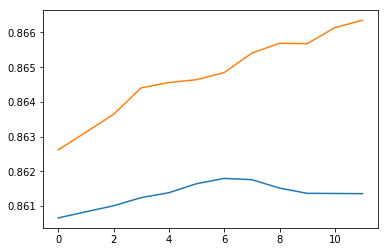

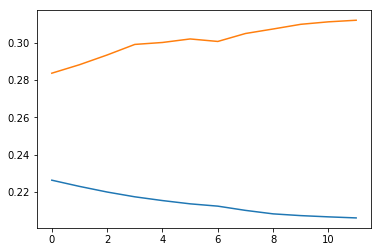

In [82]:
#sgd.get_config(); hist1.history
plt.plot(hist1.history['acc']); plt.plot(hist1.history['val_acc']); plt.show()
plt.plot(hist1.history['loss']); plt.plot(hist1.history['val_loss']); plt.show()
#hist1.history

In [83]:
#
#  Построение решения для train массива
#

# train

train = get_train(5000,0,len(labels_df),debugOK=False);

Flag, i, load_size = True, 0, 0;
try : 
    while Flag :
            xx,yy = train.next();
            i, load_size = i+1, load_size+yy.shape[0];
            print(datetime.datetime.now(),'load   : ',i,load_size,xx.shape,yy.shape) #,yy[0],yy[-1])
            assert (xx.shape[0]==yy.shape[0])

            pp   = model10.predict(xx, batch_size=batch_size)
            if (i==1) :
                trP = pp
                trY = yy
            else :
                trP = np.vstack([trP,pp])
                trY = np.vstack([trY,yy])

            if trY.shape[0]>=len(labels_df) : Flag = False;
            print(datetime.datetime.now(),'predict: ',i,trP.shape,trY.shape,Flag) #,trY[0],trY[-1])

except StopIteration as e : Flag = False;
        
finally : train.close();

# Уровни прохождения & решение
###trO01   = getProbX01(trOP,th)


2017-07-18 12:13:12.856028 load   :  1 5000 (5000, 224, 224, 3) (5000, 17)
2017-07-18 12:14:21.881332 predict:  1 (5000, 17) (5000, 17) True
2017-07-18 12:14:46.026561 load   :  2 10000 (5000, 224, 224, 3) (5000, 17)
2017-07-18 12:15:54.615203 predict:  2 (10000, 17) (10000, 17) True
2017-07-18 12:16:20.049178 load   :  3 15000 (5000, 224, 224, 3) (5000, 17)
2017-07-18 12:17:28.487401 predict:  3 (15000, 17) (15000, 17) True
2017-07-18 12:17:54.245583 load   :  4 20000 (5000, 224, 224, 3) (5000, 17)
2017-07-18 12:19:02.661616 predict:  4 (20000, 17) (20000, 17) True
2017-07-18 12:19:27.681795 load   :  5 25000 (5000, 224, 224, 3) (5000, 17)
2017-07-18 12:20:35.977732 predict:  5 (25000, 17) (25000, 17) True
2017-07-18 12:21:01.306750 load   :  6 30000 (5000, 224, 224, 3) (5000, 17)
2017-07-18 12:22:09.508568 predict:  6 (30000, 17) (30000, 17) True
2017-07-18 12:22:35.123299 load   :  7 35000 (5000, 224, 224, 3) (5000, 17)
2017-07-18 12:23:43.486803 predict:  7 (35000, 17) (35000, 17) 

In [84]:
##%time trP = model10.predict(trX, batch_size=batch_size)
trP01       = getProb01(trP)
th, _       = getTh(trY,trP)
trP01x      = getProbX01(trP,th)

In [85]:
#print(model10.evaluate(trX,trY,verbose=2,batch_size=batch_size))
print(trY.shape)
print(trP.shape)
#print('fbeta_score=',fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples'))
#print('fbeta_score=',fbeta_score(trY, np.array(trP) > 0.5, beta=2, average='samples'))
##-------------
print('fbeta_score=',fbeta_score(trY,trP01, beta=2, average='samples'))
print('fbeta_pred =',K.get_value(fbeta_pred(trY.astype(np.float64),trP01.astype(np.float64))))
##-------------
if trY.shape[1]==17 :
    print('fbeta_score=',fbeta_score(trY,trP01x, beta=2, average='samples'))
    print('fbeta_pred =',K.get_value(fbeta_pred(trY.astype(np.float64),trP01x.astype(np.float64))))

(40479, 17)
(40479, 17)
fbeta_score= 0.336726925987
fbeta_pred = 0.574324474746
fbeta_score= 0.918214429838
fbeta_pred = 0.920645115773


In [86]:
if True :
    save_model(model10,'../Data-Keras/Models/model-ResNet50-224x224x3-d4096x2.h5')
    model10.save_weights('../Data-Keras/Models/model-ResNet50-224x224x3-d-weights.h5')
    if False : # best 0x90004
        save_model(model10,'../Work/Join-XGB-NET/VGG19-LB=0x90004/model-VGG19-128x128x3-d4096xd4096.h5')
        model10.save_weights('../Work/Join-XGB-NET/VGG19-LB=0x90004/model-VGG19-128x128x3-d4096xd4096-weights.h5')
        np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trIP01-XX.npy',trP01)
        np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trIP-XX.npy', trP)
        np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trIY-YY.npy',trY)

In [87]:
model10.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 230, 230, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

In [88]:
trP[0], trY[0], trP01[0], trP01x[0]

(array([  4.92421448e-01,   3.85025799e-01,   2.22315150e-03,
          1.17272295e-01,   3.22411623e-04,   1.47330647e-05,
          1.04275846e-03,   5.18495071e-05,   5.14329113e-05,
          7.75541412e-05,   4.89034748e-04,   3.54284639e-05,
          2.03420816e-04,   2.00121958e-05,   4.60349693e-04,
          8.04330120e-05,   2.07933641e-04], dtype=float32),
 array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.], dtype=float32),
 array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8))

In [89]:
# Результативность

In [90]:
temp = estimateResult(trY,trP01x,printOK=True) # 40000 jpg224 (epoch=15,features=17) ResNet50 d4096x2 +imnet

0 acc=0.972108994787 roc=0.843029200538 not=1129 yes=1872 no=37478 true=39350 all-1-0=(0.6941-0.9920)
1 acc=0.96694582376 roc=0.839337566393 not=1338 yes=37095 no=2046 true=39141 all-1-0=(0.9889-0.6898)
2 acc=0.914350650955 roc=0.901139445818 not=3467 yes=10682 no=26330 true=37012 all-1-0=(0.8674-0.9349)
3 acc=0.964771857012 roc=0.948759576376 not=1426 yes=28099 no=10954 true=39053 all-1-0=(0.9883-0.9092)
4 acc=0.936065614269 roc=0.868842627444 not=2588 yes=5653 no=32238 true=37891 all-1-0=(0.7628-0.9749)
5 acc=0.958916969293 roc=0.830885347863 not=1663 yes=2469 no=36347 true=38816 all-1-0=(0.6746-0.9872)
6 acc=0.938684256034 roc=0.895971537366 not=2482 yes=6658 no=31339 true=37997 all-1-0=(0.8249-0.9670)
7 acc=0.92907433484 roc=0.764539590081 not=2871 yes=2477 no=35131 true=37608 all-1-0=(0.5533-0.9758)
8 acc=0.995059166481 roc=0.545330383547 not=200 yes=19 no=40260 true=40279 all-1-0=(0.0909-0.9998)
9 acc=0.986462116159 roc=0.939223759927 not=548 yes=1852 no=38079 true=39931 all-1-0=

In [117]:
temp = estimateResult(trY,trP01x,printOK=True) # 40000 jpg224 (epoch=15,features=17) ResNet50 d2048x2 +imnet

0 acc=0.965340052867 roc=0.811857957562 not=1403 yes=1712 no=37364 true=39076 all-1-0=(0.6348-0.9889)
1 acc=0.96212851108 roc=0.846674371136 not=1533 yes=36836 no=2110 true=38946 all-1-0=(0.9820-0.7114)
2 acc=0.894612021048 roc=0.877381470735 not=4266 yes=10263 no=25950 true=36213 all-1-0=(0.8334-0.9214)
3 acc=0.948738852244 roc=0.927421574474 not=2075 yes=27865 no=10539 true=38404 all-1-0=(0.9801-0.8748)
4 acc=0.914128313446 roc=0.822489536614 not=3476 yes=5024 no=31979 true=37003 all-1-0=(0.6779-0.9671)
5 acc=0.94960349811 roc=0.784303898691 not=2040 yes=2132 no=36307 true=38439 all-1-0=(0.5825-0.9861)
6 acc=0.921811309568 roc=0.859428272138 not=3165 yes=6099 no=31215 true=37314 all-1-0=(0.7557-0.9632)
7 acc=0.914029496776 roc=0.69368927423 not=3480 yes=1839 no=35160 true=36999 all-1-0=(0.4108-0.9766)
8 acc=0.994861533141 roc=0.507152201111 not=208 yes=3 no=40268 true=40271 all-1-0=(0.0144-1.0000)
9 acc=0.979199090887 roc=0.94920044725 not=842 yes=1913 no=37724 true=39637 all-1-0=(0.

In [312]:
temp = estimateResult(trY,trP01x,printOK=True) # 40000 jpg128 (epoch=40,features=17) VGG19 d4096+d4096 +weights+imnet LB=0.90004

0 acc=0.970824378073 roc=0.827535509167 not=1181 yes=1786 no=37512 true=39298 all-1-0=(0.6622-0.9929)
1 acc=0.976555744954 roc=0.877590365212 not=949 yes=37271 no=2259 true=39530 all-1-0=(0.9935-0.7616)
2 acc=0.917611601077 roc=0.909720294098 not=3335 yes=10955 no=26189 true=37144 all-1-0=(0.8896-0.9299)
3 acc=0.964376590331 roc=0.949960875432 not=1442 yes=28021 no=11016 true=39037 all-1-0=(0.9856-0.9143)
4 acc=0.937943131006 roc=0.87391779368 not=2512 yes=5728 no=32239 true=37967 all-1-0=(0.7729-0.9749)
5 acc=0.954074952444 roc=0.807677321803 not=1859 yes=2302 no=36318 true=38620 all-1-0=(0.6290-0.9864)
6 acc=0.942711035352 roc=0.901277662688 not=2319 yes=6718 no=31442 true=38160 all-1-0=(0.8324-0.9702)
7 acc=0.928012055634 roc=0.768147534975 not=2914 yes=2520 no=35045 true=37565 all-1-0=(0.5629-0.9734)
8 acc=0.994861533141 roc=0.507152201111 not=208 yes=3 no=40268 true=40271 all-1-0=(0.0144-1.0000)
9 acc=0.990464191309 roc=0.950839323708 not=386 yes=1894 no=38199 true=40093 all-1-0=(

In [59]:
if False :
    K.clear_session()
    model10 = load_model('../Data-Keras/Models/model-ResNet50-224x224x3-d.h5')
    model10.summary()

In [50]:
#model.load_weights('../Data-Keras/train-model-2D-2-v2-loop-weights.h5') ## verify load weights from v1 version

In [60]:
# Forming output dataset for predicting --> trOX, trOY
#del(trX)
#del(trY)

In [91]:
def generate_test ( dirIn, output_shape, size=5000, preprocess=True, debugOK=False) :
    
    xx = np.zeros((size,output_shape[0],output_shape[1],output_shape[2]),dtype=np.float32);
    yy = np.array((size,output_shape[0],output_shape[1],output_shape[2]));
    
    iijj = 0;
    
    names_files = np.array(os.listdir(dirIn));
    if debugOK : 
        print('generate_test: names_files={} size={} dirIn={}'.format(len(names_files),size,dirIn))
        names_files = names_files[:1000]
        print(names_files.shape)
    
    for ii in range(0,names_files.shape[0],size) :
        ###if debugOK : print('generate_test: ii={}'.format(ii))
        yy    = names_files[ii:min(ii+size,names_files.shape[0])];
        files = names_files[ii:min(ii+size,names_files.shape[0])].tolist()
        #################files = [x+ext for x in files]
        if len(files)<size :
            xx = np.zeros((len(files),output_shape[0],output_shape[1],output_shape[2]),dtype=np.float32);
        for i in range(len(files)) :
            nf    = os.path.join(dirIn,files[i])
            xx[i] = formImExt(nf,EqualizeOK=False,resize=(output_shape[0],output_shape[1]))
            iijj += 1
            ##if (iijj%5000)==0 : print (datetime.datetime.now(),'-->',iijj)
        if preprocess : xx    = preprocess_input(xx)
        yield xx,yy

In [92]:
if False : # small testing
    test = generate_test(teDirJPG,sizing,size=10000,debugOK=True);
    Flag, i, load_size = True, 0, 0;
    while Flag :
        try : 
            xx,yy = test.next();
            i, load_size = i+1, load_size+yy.shape[0];
            print(datetime.datetime.now(),i,load_size,xx.shape,yy.shape,yy[0],yy[-1])
            assert (xx.shape[0]==yy.shape[0])
        except StopIteration as e : Flag = False;
    test.close();


In [93]:
#
#  Построение решения для test массива на основе уровней прохождения (эффект почему-то дают)
#    Построенное решение 01 полное с учетом погодных критериев [0,3,9,10]
#        и особенности критерия cloudy (посмотреть и сменить можно в getProbX01)
#        Построение критериев прохождения в getTh
#

# test

test = generate_test(teDirJPG,sizing,size=10000,debugOK=False);
Flag, i, load_size = True, 0, 0;
try : 
    while True :
            xx,yy = test.next();
            i, load_size = i+1, load_size+yy.shape[0];
            print(datetime.datetime.now(),'load   : ',i,load_size,xx.shape,yy.shape,yy[0],yy[-1])
            assert (xx.shape[0]==yy.shape[0])

            pp   = model10.predict(xx, batch_size=batch_size)
            if (i==1) :
                trOP = pp
                trOY = yy
            else :
                trOP = np.vstack([trOP,pp])
                trOY = np.hstack([trOY,yy])

            print(datetime.datetime.now(),'predict: ',i,trOP.shape,trOY.shape,trOY[0],trOY[-1])

except StopIteration as e : Flag = False;
        
finally : test.close();

# Уровни прохождения & решение
trO01   = getProbX01(trOP,th)


2017-07-18 12:35:48.404193 load   :  1 10000 (10000, 224, 224, 3) (10000,) test_10002.jpg test_19029.jpg
2017-07-18 12:38:08.469631 predict:  1 (10000, 17) (10000,) test_10002.jpg test_19029.jpg
2017-07-18 12:38:33.477722 load   :  2 20000 (10000, 224, 224, 3) (10000,) test_1903.jpg test_28015.jpg
2017-07-18 12:40:50.206918 predict:  2 (20000, 17) (20000,) test_10002.jpg test_28015.jpg
2017-07-18 12:41:14.585771 load   :  3 30000 (10000, 224, 224, 3) (10000,) test_28016.jpg test_37026.jpg
2017-07-18 12:43:34.634195 predict:  3 (30000, 17) (30000,) test_10002.jpg test_37026.jpg
2017-07-18 12:43:59.958093 load   :  4 40000 (10000, 224, 224, 3) (10000,) test_37027.jpg test_9402.jpg
2017-07-18 12:46:16.800430 predict:  4 (40000, 17) (40000,) test_10002.jpg test_9402.jpg
2017-07-18 12:46:41.769191 load   :  5 50000 (10000, 224, 224, 3) (10000,) test_9403.jpg file_18419.jpg
2017-07-18 12:49:01.936656 predict:  5 (50000, 17) (50000,) test_10002.jpg file_18419.jpg
2017-07-18 12:49:45.905398 lo

In [94]:
trOP[0]

array([  1.68812694e-03,   2.47392785e-02,   4.60817572e-03,
         1.69968233e-01,   5.65646231e-01,   5.25681753e-05,
         5.13295061e-04,   1.41862020e-05,   2.28845729e-05,
         2.13056833e-01,   1.36240458e-04,   2.40921727e-05,
         1.94734316e-02,   1.88178747e-05,   4.81315283e-06,
         1.28220454e-05,   2.00439845e-05], dtype=float32)

In [95]:
#trO01[0:3],np.array(th),trOP[0:3]
if False :
    np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trO01-OX.npy',trO01)
    np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trOP-OX.npy', trOP)
    np.save('../Work/Join-XGB-NET/VGG19-LB=0x90004/trOY-OY.npy',trOY)

In [96]:
# Строим результат

In [97]:
trZ = trO01
trOY_old = trOY
trOY_old[0]

'test_10002.jpg'

In [98]:
trOY = trOY_old.tolist(); type(trOY), len(trOY)
trOY = [os.path.splitext(xx)[0] for xx in trOY]; trOY[0]

'test_10002'

In [99]:
temp_list = []
for i in range(trZ.shape[0]) :
    temp = [labels[ii] for ii in range(trZ.shape[1]) if trZ[i,ii]==1];
    temp = ' '.join(temp)
    temp_list.append([trOY[i],temp])
temp_list.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))


In [100]:
temp_list[0:5]

[['test_0', 'primary clear'],
 ['test_1', 'primary clear'],
 ['test_2', 'primary partly_cloudy'],
 ['test_3', 'primary clear'],
 ['test_4', 'cloudy']]

In [101]:
rrr=pd.DataFrame(temp_list,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-07-18-12-52-43


In [102]:
rrr.head()

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,primary clear
4,test_4,cloudy
